In [102]:
import sqlite3
db = sqlite3.connect('../datasets/new.db')

In [103]:
LABEL_COUNT = db.execute("""SELECT COUNT(1) FROM Evaluations""").fetchone()[0]
print(LABEL_COUNT)

37164639


In [104]:
BATCH_SIZE = 10240

In [115]:
from torch.utils.data import IterableDataset
import random

def bytes_to_i8_list(bytes_obj):
    return [(b if b < 128 else b - 256) for b in bytes_obj]

class EvaluationDataset(IterableDataset):
    def __init__(self, db: sqlite3.Connection, count: int, batch_size: int):
        self.db = db
        self.batch_size = batch_size
        self.batch_starts = list(range(0, count, self.batch_size))
        self.remaining_batches = list(self.batch_starts)

    def __iter__(self):
        return self 

    def __len__(self):
        return len(self.batch_starts)
    
    def reset(self):
        self.remaining_batches = list(self.batch_starts)

    

    def __next__(self):
        if len(self.remaining_batches)==0:
            # all batches sampled, reset the remaining_batches list
            self.reset()

        # pick a random batch index from the remaining list and remove it
        batch_index = random.sample(self.remaining_batches, 1)[0]
        self.remaining_batches.remove(batch_index)

        rows = self.db.execute("""
            SELECT
                input_tensor,
                eval_for_white
            FROM Evaluations
            LIMIT ? OFFSET ?
        """, (self.batch_size, batch_index)).fetchall()
        batch = {
            'input_tensors': torch.as_tensor([bytes_to_i8_list(row[0]) for row in rows], dtype=torch.float16),
            'evals_for_white': torch.as_tensor([row[1] for row in rows], dtype=torch.float16),
        }
        return batch
    
dataset = EvaluationDataset(db, LABEL_COUNT, BATCH_SIZE)

In [116]:
next(dataset).keys()

dict_keys(['input_tensors', 'evals_for_white'])

In [117]:
dataset.reset()

In [118]:
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=None, # we batch in the dataset
    # num_workers=12,
    pin_memory=True,
)

In [119]:
import pytorch_lightning as pl
import torch.nn.functional as F
import torch
from torch import nn
from collections import OrderedDict

class EvaluationModel(pl.LightningModule):
    def __init__(
        self,
        dataloader: DataLoader,
        learning_rate: float,
    ):
        super().__init__()
        self.dataloader = dataloader
        self.learning_rate = learning_rate
        
        # Define the layer sizes
        layer_sizes = [65, 32, 30, 21, 1]
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append((f"linear-{i}", nn.Linear(layer_sizes[i], layer_sizes[i + 1])))
            
            # We don't want ReLU activation after the last linear layer
            if i != len(layer_sizes) - 2:
                layers.append((f"relu-{i}", nn.ReLU()))
                
        self.seq = nn.Sequential(OrderedDict(layers))

    def forward(self, x):
        return self.seq(x)

    def training_step(self, batch):
        x, y = batch['input_tensors'], batch['evals_for_white']
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def train_dataloader(self):
        return self.dataloader

In [120]:
model = EvaluationModel(
    dataloader, 
    learning_rate=1e-3,
).to("cuda")

In [121]:
from pathlib import Path

checkpoint_dir = Path("models")
checkpoint_dir.mkdir(exist_ok=True)
found = sorted(list(checkpoint_dir.glob("*")))
if len(found) > 0:
    latest = found[-1]
    print("Loading latest checkpoint:", latest)
    model.load_state_dict(torch.load(latest))

Loading latest checkpoint: models\model2-withturn-1690439187.pt


In [122]:
import time
version_name = f'{int(time.time())}-batch_size-{BATCH_SIZE}'
logger = pl.loggers.TensorBoardLogger(
    "lightning_logs",
    name="chess",
    version=version_name,
)

trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    max_epochs=1,
    logger=logger,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [123]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 20068), started 0:10:54 ago. (Use '!kill 20068' to kill it.)

In [154]:
trainer.fit(model)

c:\Users\TeamD\.conda\envs\chess2\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory lightning_logs\chess\1690567352-batch_size-10240\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | seq  | Sequential | 3.8 K 
------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
c:\Users\TeamD\.conda\envs\chess2\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  ran

In [125]:
torch.save(model.state_dict(), checkpoint_dir / f"model3-normevalbetterloader-{int(time.time())}.pt")

In [181]:
test = db.execute(
    """
        SELECT
            id,
            fen,
            input_tensor,
            eval_for_white
        FROM Evaluations
        LIMIT ?
        OFFSET ?
    """,
    (
        10000,
        random.randrange(LABEL_COUNT)
    ),
).fetchall()

import chess
from IPython.display import display

stats = []
for row in test:
    id, fen, input_tensor, eval_for_white = row
    x = torch.as_tensor([bytes_to_i8_list(input_tensor)], dtype=torch.float32).cuda()
    y = eval_for_white
    y_pred = model(x)*10
    # print(fen)
    # print("expected", y)
    # print("predicted", y_pred.item())
    matches = (y_pred.item() > 0) == (y > 0)
    # print("sign matches", matches)
    stats.append(matches)
    # board = chess.Board(fen)
    # display(board)
print("accuracy", sum(stats)/len(stats))


accuracy 0.5065


In [190]:
import chess


def fen_as_input(fen: str):
    import chess
    board = chess.Board(fen)
    inputs = torch.zeros(65, dtype=torch.float16)
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            inputs[i] = piece.piece_type * (1 if piece.color == chess.WHITE else -1)
    inputs[64] = 1 if board.turn == chess.WHITE else -1 # forgor this earlier ☠
    inputs = torch.as_tensor(inputs, dtype=torch.float32).unsqueeze(0).cuda()
    return inputs

fen = test[0][1]
print(fen)
print(fen_as_input(fen))

r3k2r/pp3p2/4pq1p/3pnb2/2pP1R2/P1P3P1/2P1P1BP/R2Q2K1 w kq - 0 15
tensor([[ 4.,  0.,  0.,  5.,  0.,  0.,  6.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
          3.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0., -1.,  1.,
          0.,  4.,  0.,  0.,  0.,  0.,  0., -1., -2., -3.,  0.,  0.,  0.,  0.,
          0.,  0., -1., -5.,  0., -1., -1., -1.,  0.,  0.,  0., -1.,  0.,  0.,
         -4.,  0.,  0.,  0., -6.,  0.,  0., -4.,  1.]], device='cuda:0')


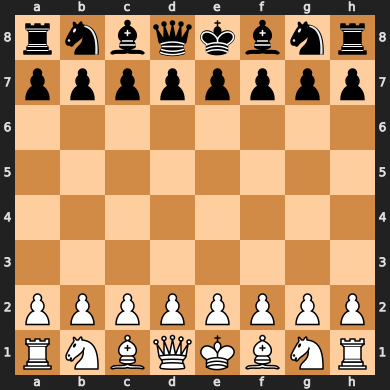

model move


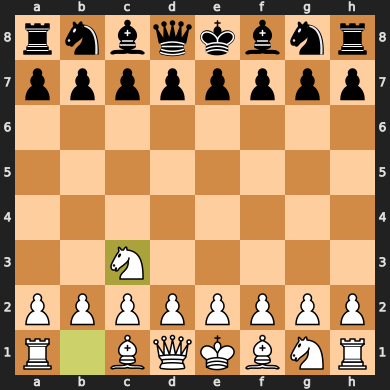

engine move
<PlayResult at 0x283455402e0 (move=d7d5, ponder=d2d4, info={}, draw_offered=False, resigned=False)>


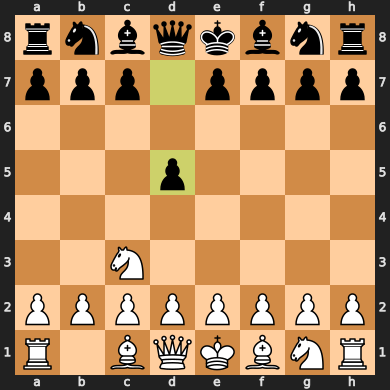

model move


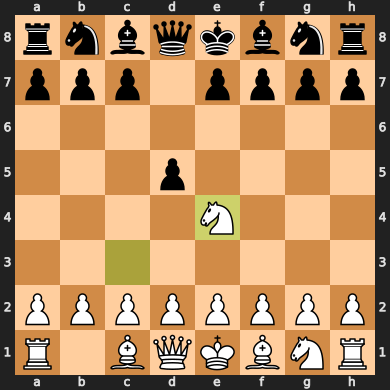

engine move
<PlayResult at 0x283451814e0 (move=d5e4, ponder=f2f3, info={}, draw_offered=False, resigned=False)>


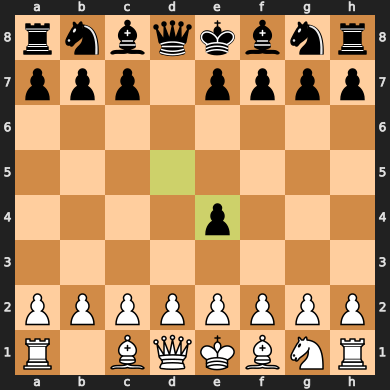

model move


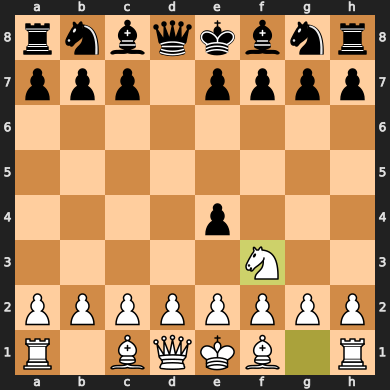

engine move
<PlayResult at 0x28345181540 (move=e4f3, ponder=d2d4, info={}, draw_offered=False, resigned=False)>


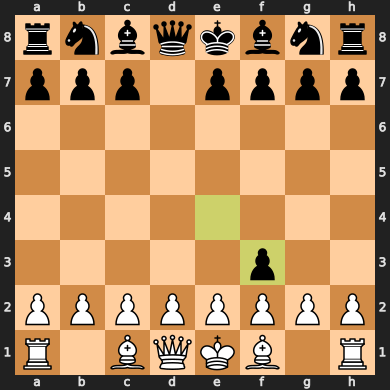

model move


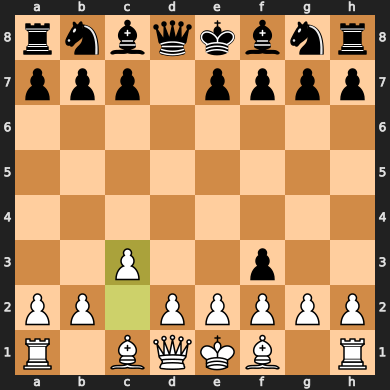

engine move
<PlayResult at 0x283451811b0 (move=f3e2, ponder=f1e2, info={}, draw_offered=False, resigned=False)>


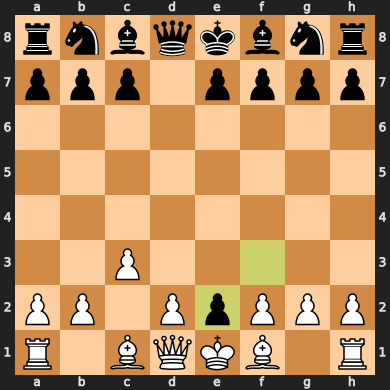

model move


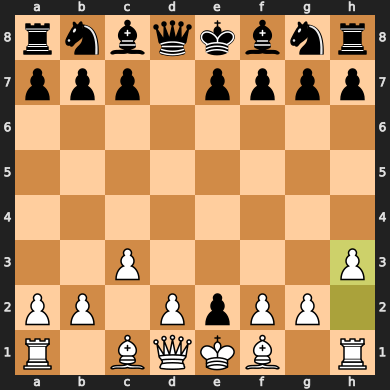

engine move
<PlayResult at 0x283451808e0 (move=e2d1r, ponder=e1d1, info={}, draw_offered=False, resigned=False)>


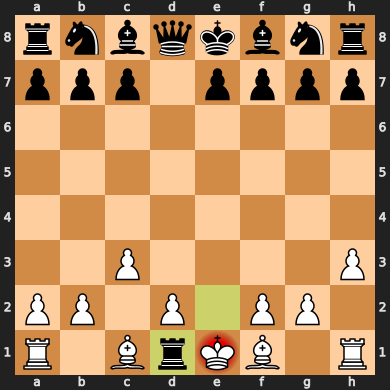

model move


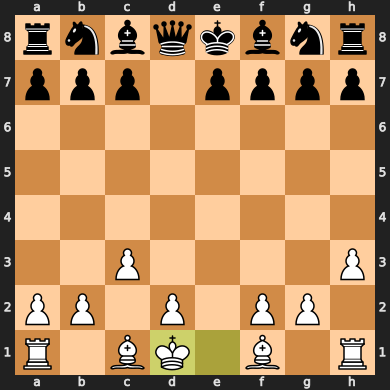

engine move
<PlayResult at 0x28345180e80 (move=d8d5, ponder=h1g1, info={}, draw_offered=False, resigned=False)>


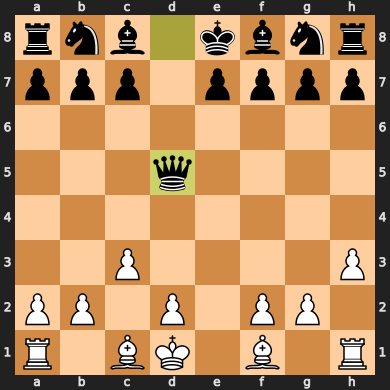

model move


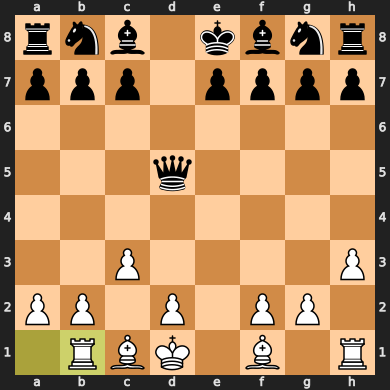

engine move
<PlayResult at 0x283451826e0 (move=d5a2, ponder=f1d3, info={}, draw_offered=False, resigned=False)>


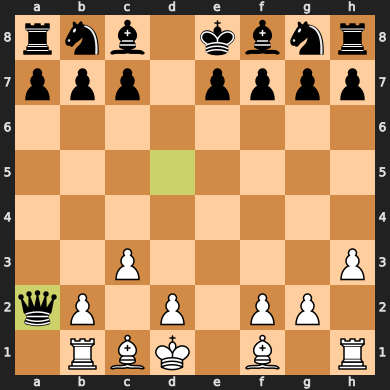

model move


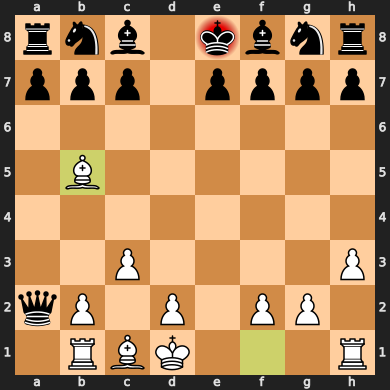

engine move
<PlayResult at 0x28345182650 (move=b8c6, ponder=b5d3, info={}, draw_offered=False, resigned=False)>


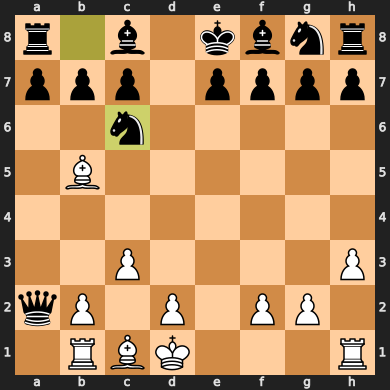

model move


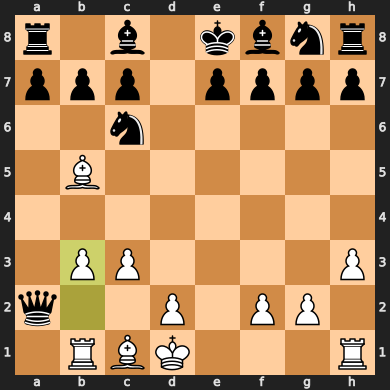

engine move
<PlayResult at 0x28345182da0 (move=a2b1, ponder=b3b4, info={}, draw_offered=False, resigned=False)>


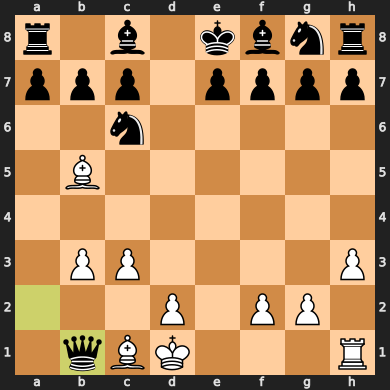

model move


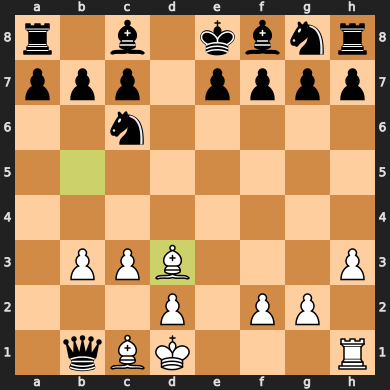

engine move
<PlayResult at 0x28345183400 (move=b1d3, ponder=d1e1, info={}, draw_offered=False, resigned=False)>


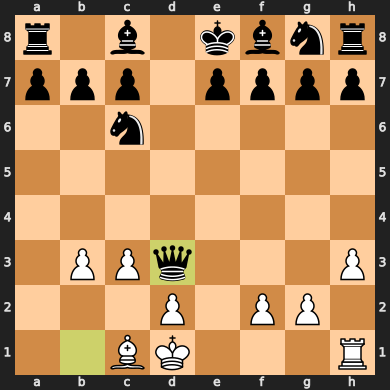

model move


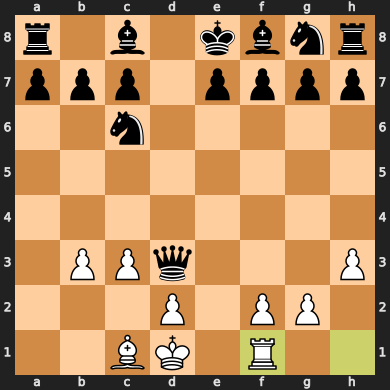

engine move
<PlayResult at 0x28345183340 (move=d3f1, ponder=d1c2, info={}, draw_offered=False, resigned=False)>


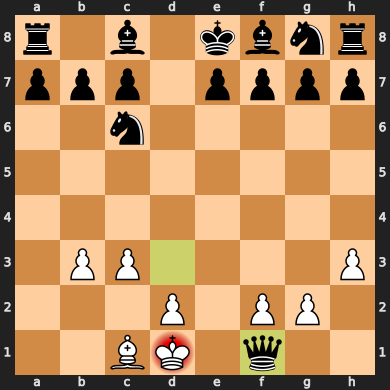

model move


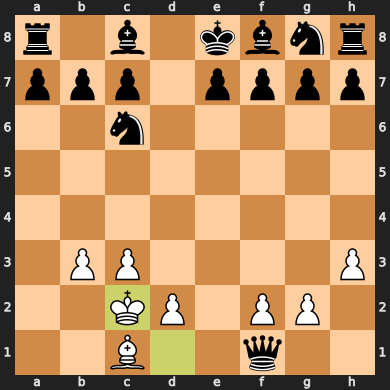

engine move
<PlayResult at 0x28345182fb0 (move=c8f5, ponder=c2b2, info={}, draw_offered=False, resigned=False)>


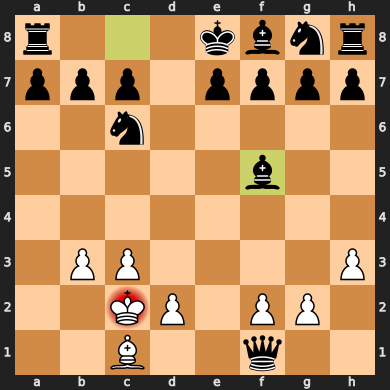

model move


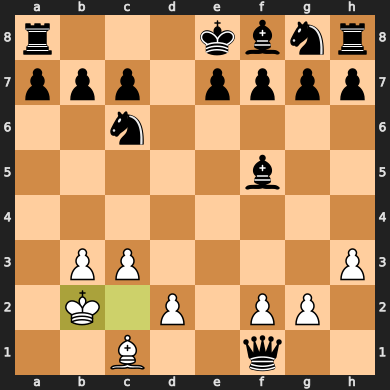

engine move
<PlayResult at 0x283451806d0 (move=f1d3, ponder=b2a3, info={}, draw_offered=False, resigned=False)>


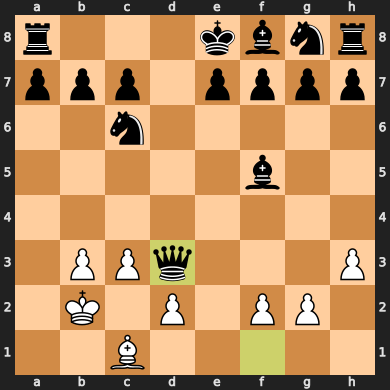

model move


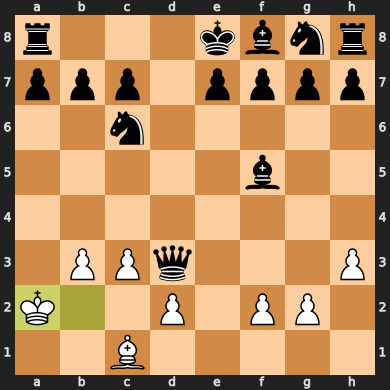

engine move
<PlayResult at 0x28345181c00 (move=d3b1, ponder=a2a3, info={}, draw_offered=False, resigned=False)>


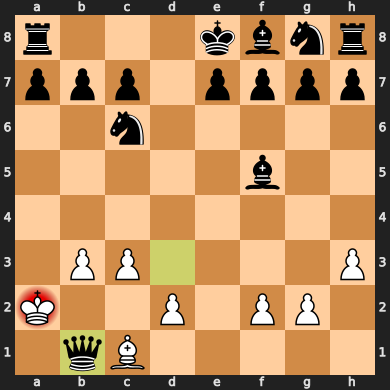

model move


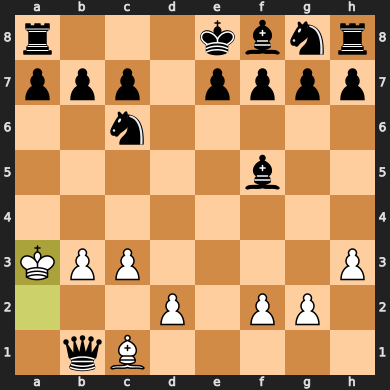

engine move
<PlayResult at 0x283451812a0 (move=b1a1, ponder=None, info={}, draw_offered=False, resigned=False)>


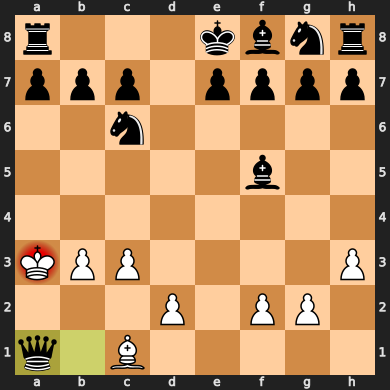

In [200]:
import chess.engine

engine = chess.engine.SimpleEngine.popen_uci(r"..\..\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe")

board: chess.Board = chess.Board()
display(board)

while not board.is_game_over():
    best_move = None
    best_move_eval = None
    print("model move")
    for move in board.legal_moves:
        board.push(move)
        x = fen_as_input(board.fen())
        board.pop()
        y_pred = model(x).item()
        if best_move_eval is None or y_pred > best_move_eval:
            best_move = move
            best_move_eval = y_pred
    board.push(best_move)
    display(board)

    print("engine move")
    result = engine.play(board, chess.engine.Limit(time=1.0))
    print(result)
    board.push(result.move)
    display(board)